In [93]:
from __future__ import absolute_import, division, print_function
import torch
from torch.distributions import constraints
from torch.nn import Parameter
import pyro
from pyro.contrib.gp.util import Parameterized
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
from pyro.params import param_with_module_name
import pyro.contrib.gp as gp
import pyro.distributions as dist
import matplotlib.pyplot as plt
pyro.clear_param_store()
import tensorflow as tf
import numpy as np 
import pandas as pd
import numpy
import math
import cProfile
import time
import GPy
import numpy as np
from matplotlib import pyplot as plt

import statsmodels.api as sm
import sympy as sp
#import pymc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.special import gamma
from GPy.core.parameterization.variational import NormalPosterior, NormalPrior

from sympy.interactive import printing
import pyro.contrib.gp.models.vsgp as vsgp
from GPy.util.linalg import pdinv
from pyro.infer.mcmc.hmc import HMC
from pyro.infer.mcmc import MCMC
from matplotlib import pyplot
pyro.clear_param_store()
import time
torch.manual_seed(12)
pyro.set_rng_seed(101)

In [94]:
# Load the Dataset
y = torch.stack([dist.Normal(4.8, 0.1).sample((150,)),dist.Normal(3.2, 0.3).sample((150,)),dist.Normal(1.5, 0.4).sample((150,)),
 dist.Exponential(0.5).sample((150,))])
X_loc = torch.zeros(150, 2)
kernel = gp.kernels.RBF(input_dim=2,lengthscale=torch.ones(1),variance=torch.ones(1))
Xu = torch.zeros(20, 2)
gpmodel = gp.models.SparseGPRegression(X_loc, y, kernel, Xu, noise=torch.tensor(1.))
gplvm = gp.models.GPLVM(gpmodel)

CPU+SystemTime:90.140625 seconds
Code Run Time:59.14876890182495 seconds


Text(0.5,1,'Convergence of SVI')

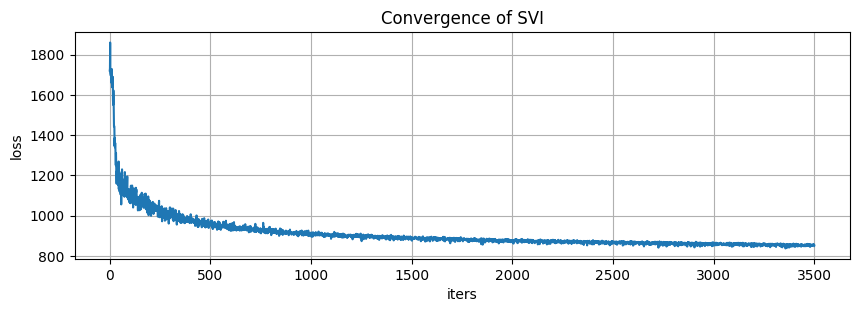

In [95]:
i=list(range(1,3501))
st = time.process_time()
st2 = time.time()
losses = gplvm.optimize(num_steps=3500)  # doctest: +SKIP
end =  time.process_time()
end2 = time.time()
print(str('CPU+SystemTime:')+str(end-st)+' '+str('seconds'))
print(str('Code Run Time:')+str(end2-st2)+' '+str('seconds'))
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(i,losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.grid()
pyplot.title('Convergence of SVI')



In [96]:
X = gplvm.get_param("X_loc")
X_var = gplvm.get_param("X_scale_tril")
Kfu = gplvm.base_model.kernel(X, gplvm.base_model.Xu).detach().numpy()
Kuu = gplvm.base_model.kernel(gplvm.base_model.Xu, gplvm.base_model.Xu).detach().numpy()
Kuf = Kfu.T
print('Kfu shape'+str(Kfu.shape))
print('Kuu shape'+str(Kuu.shape))
print('Kuf shape'+str(Kuf.shape))
noise = gplvm.base_model.get_param('noise').detach().numpy()
K = np.dot(np.dot(Kfu,pdinv(Kuu)[0]),Kuf)  + np.eye(X.shape[0])*(1/noise)

Kfu shape(150, 20)
Kuu shape(20, 20)
Kuf shape(20, 150)


 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1867: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


(0, 1)

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


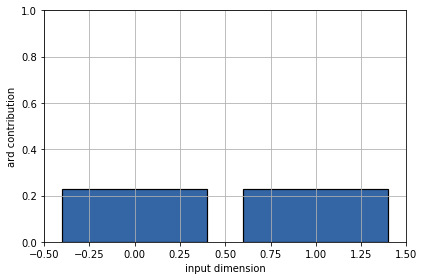

In [97]:
active = gplvm.base_model.kernel.active_dims
input_dim = gplvm.base_model.kernel.input_dim
Var = gplvm.base_model.kernel.get_param('variance').detach().numpy()
Len = gplvm.base_model.kernel.get_param('lengthscale').detach().numpy()
Co = GPy.kern.RBF(ARD=True,active_dims=active,input_dim=input_dim,lengthscale=Len,variance=Var)
Co.K = K
Co.plot_ARD()
plt.grid()
plt.ylim([0,1])
# Inverse Length Parameter

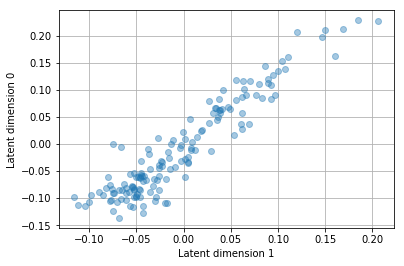

In [98]:
plt.plot(X[:,1].detach().numpy(),X[:,0].detach().numpy(),linestyle="",alpha=0.4,marker="o")
pyplot.xlabel('Latent dimension 1')
pyplot.ylabel('Latent dimension 0')
pyplot.grid()

In [99]:
Y = numpy.array(y)
Y = Y.T
dd_orig = distance_matrix(Y)
dd_proj = distance_matrix(X)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)

Neearest neighbourboost size k =5 Continuity:0.8677276995305164
Neearest neighbourboost size k =10 Continuity:0.8777794299876084
Neearest neighbourboost size k =20 Continuity:0.8971910739191074
Neearest neighbourboost size k =40 Continuity:0.9310633147113594
Neearest neighbourboost size k =60 Continuity:0.9488646125116713
Neearest neighbourboost size k =75 Continuity:0.9505945945945946


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

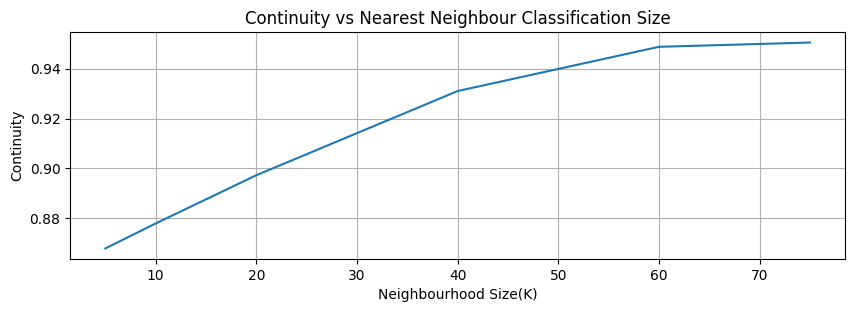

In [100]:
ks=[5,10,20,40,60,75]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
pyplot.grid()
#pyplot.yscale('log')
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =5 Trust:0.8467699530516433
Neearest neighbourboost size k =10 Trust:0.8677026022304832
Neearest neighbourboost size k =20 Trust:0.8871548117154812
Neearest neighbourboost size k =40 Trust:0.922147113594041
Neearest neighbourboost size k =60 Trust:0.934235294117647
Neearest neighbourboost size k =75 Trust:0.9318486486486487


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

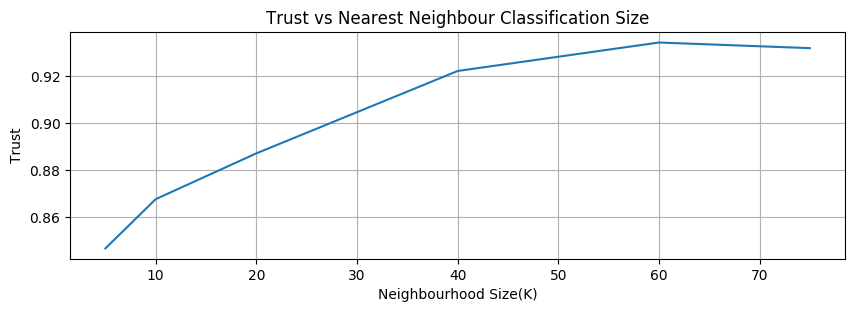

In [101]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

# Bayesian GPLVM 

In [102]:
Y = numpy.array(y)
Y = Y.T
kernel = GPy.kern.RBF(2, ARD=True,variance=1.0,lengthscale=1.0)
m = GPy.models.BayesianGPLVM(Y, 2,  init="PCA",kernel=kernel,num_inducing=20)
m.data_labels = Y.argmax(axis=1)
loss = m.optimize('scg', messages=1,max_iters=10000)

Running Scaled Conjugate Gradients Code:
  runtime   i       f              |g|        
    00s08  00007   7.834785e+03   1.717611e+04 
    00s19  00015   9.464446e+02   6.587633e+03 
    01s20  00123   5.342629e+02   3.653967e+02 
    04s20  00446   4.517368e+02   6.522669e+01 

 /home/aneeqr/.local/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /home/aneeqr/.local/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:invalid value encountered in add
 /home/aneeqr/.local/lib/python3.6/site-packages/GPy/kern/src/stationary.py:136: RuntimeWarning:overflow encountered in square


    05s21  00548   4.432576e+02   1.201370e+02 
    08s97  00939   4.199343e+02   3.922819e+02 
Runtime:     08s97
Optimization status: converged - relative stepsize



 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


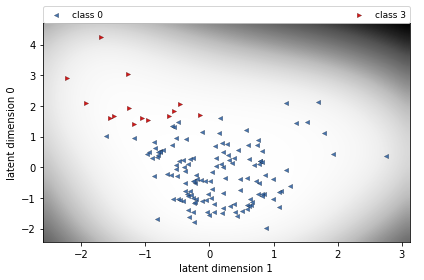

In [70]:
#plt.plot(m.X.mean[:,1],m.X.mean[:,0],linestyle="",alpha=0.4,marker="o")
m.plot_latent(m.data_labels)
#pyplot.xlabel('Latent dimension 1')
#pyplot.ylabel('Latent dimension 0')
pyplot.grid()

In [103]:
Kfu2 =  m.kern.K(m.X.mean, m.Z)
Kuu2 = m.kern.K(m.Z, m.Z)
Kuf2 = Kfu2.T 
print('Kfu shape'+str(Kfu2.shape))
print('Kuu shape'+str(Kuu2.shape))
print('Kuf shape'+str(Kuf2.shape))

Kfu shape(150, 20)
Kuu shape(20, 20)
Kuf shape(20, 150)


In [104]:
Kff = np.dot(np.dot(Kfu2,pdinv(Kuu2)[0]),Kuf2)
Kff = Kff + np.eye(m.X.mean.shape[0])*(1/m.Gaussian_noise.variance)

In [105]:
Samples=1000
VS = [] # Vector Containing Matrix Samples (Xs)
for i in range(Samples):
    VS.append(pyro.sample('Variational Distibtuion',dist.MultivariateNormal(gplvm.get_param("X_loc"), scale_tril=gplvm.get_param("X_scale_tril")).independent(gplvm.get_param("X_loc").dim()-1),))

In [127]:
def Joint_Prob(Y,Xs,N,D,Q,m,K_new):
    K_inv = np.linalg.inv(K_new)
    #K_inv = pdinv(K_new)[0]
    Prob = -N*D*0.5*np.log(2*np.pi) - D/2*np.log(np.linalg.det(K_new))-1/2*np.trace(np.matmul(np.matmul(Y.T,K_inv),Y)) - (N*Q/2)*np.log(2*np.pi)-0.5*np.trace(np.matmul(Xs,Xs.T))
    return Prob 

In [128]:
N= y.shape[0]
Q = 2
D=4
Join = []
for sample in VS:
    Join.append(Joint_Prob(Y,sample.detach().numpy(),N,D,Q,m,Kff))

## ARD Contribution

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1867: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


(0, 2)

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


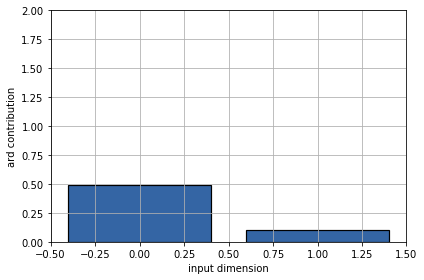

In [108]:
m.kern.plot_ARD()
plt.grid()
plt.ylim([0,2])

In [129]:
def Var(X,gplvm,D,K_new):
    #K_inv = np.linalg.inv(K_new)
    K_inv = pdinv(K_new)[0]
    temp = np.matmul(np.matmul(X.detach().numpy().T,K_inv),X.detach().numpy()) 
    qx = -0.5*(K.shape[0]*(D))*(np.log(np.pi*2)) - D/2*np.log(np.linalg.det(K_new)) - 0.5*np.trace(temp)
    return qx

In [135]:
qx = []
for sample in VS:
    qx.append(Var(sample,gplvm=gplvm,D=2,K_new=K))

In [136]:
Rs,Rs2 = log_Ratios(qx,Join)

In [137]:
print('K:'+ str(psisloo(np.array(Rs2)))) 

K:(707.8064786075303, 707.8064786075303, 0.38920762869068315)


In [113]:
y

tensor([[ 4.7397,  4.7879,  4.7568,  4.9881,  4.7284,  4.8003,  4.8206,
          4.8563,  4.8279,  4.6913,  4.8061,  4.8909,  4.7587,  4.7806,
          4.5817,  4.8719,  4.6543,  4.7012,  4.9055,  4.8778,  4.9067,
          4.8114,  4.7442,  4.8307,  4.7376,  4.7829,  4.8919,  4.8560,
          4.9772,  4.7038,  4.8061,  4.7094,  4.7077,  4.8387,  4.6935,
          4.7757,  4.6813,  4.8856,  4.7561,  4.7481,  4.8376,  4.7198,
          4.7465,  4.7112,  4.8732,  4.7024,  4.9527,  4.7450,  4.9508,
          4.9032,  4.7939,  4.7918,  4.8090,  4.7087,  4.8286,  4.8164,
          4.9308,  4.7708,  4.6746,  4.8795,  4.7177,  4.7717,  4.7460,
          4.8349,  4.7409,  4.8978,  4.6963,  4.8071,  4.8284,  4.8810,
          4.9525,  4.8790,  4.8130,  4.7314,  4.7655,  4.7968,  4.5670,
          4.7328,  5.0160,  4.7448,  4.9160,  4.8090,  4.7145,  4.9675,
          4.8727,  4.7734,  5.0376,  4.7487,  4.6348,  4.7554,  4.7742,
          4.8703,  4.9111,  4.7108,  4.8969,  4.8493,  4.8977,  

List of 2
 - $ log_weights: num [1:1000, 1] -704 -704 -704 -704 -704 ...
 - $ diagnostics:List of 2
 - ..$ pareto_k: num 0.42
 
 - ..$ n_eff   : num 1000
 
 - attr(*, "norm_const_log")= num -697
 - attr(*, "tail_len")= num 95
 - attr(*, "r_eff")= num 1
 - attr(*, "dims")= int [1:2] 1000 1
 - attr(*, "class")= chr [1:2] "psis" "list"

In [114]:
thefile = open('tester9.txt', 'w')
for item in Rs2:
    thefile.write("%s\n" % item)

Neearest neighbourboost size k =5 Continuity:0.9722723004694835
Neearest neighbourboost size k =10 Continuity:0.9687682775712515
Neearest neighbourboost size k =20 Continuity:0.9619497907949791
Neearest neighbourboost size k =40 Continuity:0.9576089385474861
Neearest neighbourboost size k =60 Continuity:0.9532231559290383
Neearest neighbourboost size k =75 Continuity:0.9349669669669669


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

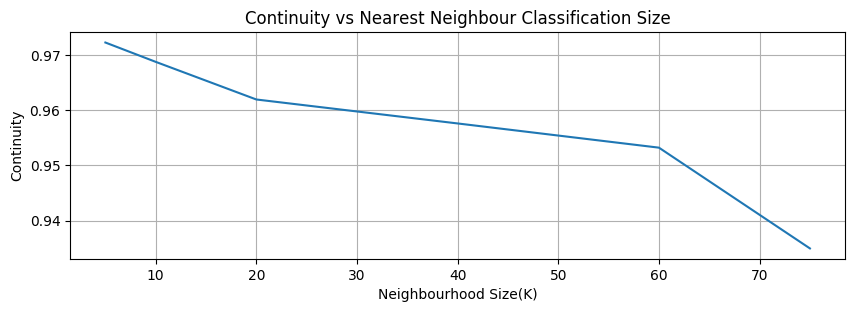

In [115]:
X0= list(m.X.mean[:,0])
X1= list(m.X.mean[:,1])
t= np.column_stack((X0, X1))
dd_proj = distance_matrix(t)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)

ks=[5,10,20,40,60,75]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
#pyplot.yscale('log')
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =5 Trust:0.9546948356807512
Neearest neighbourboost size k =10 Trust:0.9586765799256506
Neearest neighbourboost size k =20 Trust:0.9611938633193864
Neearest neighbourboost size k =40 Trust:0.9608603351955307
Neearest neighbourboost size k =60 Trust:0.9537721755368814
Neearest neighbourboost size k =75 Trust:0.936148948948949


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

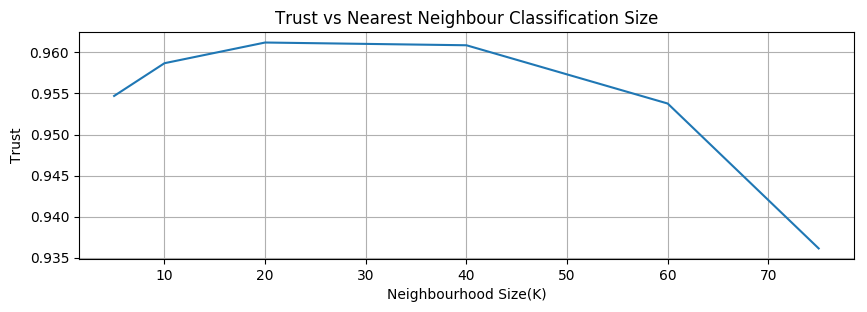

In [116]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
#pyplot.yscale('log')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

# MARKOV CHANGE MONTE CARLO

In [175]:
def model(y):
        X_loc = torch.zeros(y.shape[1], 2)
        kernel = gp.kernels.RBF(input_dim=2, lengthscale=torch.ones(2))
        Xu = torch.zeros(20, 2)  # initial inducing inputs of sparse model
        gpmodel = gp.models.SparseGPRegression(X_loc, y, kernel, Xu, noise=torch.tensor(1.))
        X_loc = gpmodel.X
        C = X_loc.shape[1]
        Id = torch.eye(C, out=X_loc.new_empty(C, C))
        zero_loc = X_loc.new_zeros(X_loc.shape)
        X = pyro.sample('Var_dist', dist.MultivariateNormal(zero_loc, scale_tril=Id)
                                    .independent(zero_loc.dim()-1))
        return X

In [176]:
hmc_kernel = HMC(model, step_size=0.0855, num_steps=4,adapt_step_size=True)
mcmc_run = MCMC(hmc_kernel, num_samples=500, warmup_steps=100).run(y)

In [177]:
posterior = pyro.infer.abstract_infer.EmpiricalMarginal(mcmc_run)

In [178]:
Samples = posterior.sample_n(1000)

 /home/aneeqr/.local/lib/python3.6/site-packages/torch/distributions/distribution.py:112: UserWarning:sample_n will be deprecated. Use .sample((n,)) instead


In [179]:
trace_log_pdf = []
for tr in mcmc_run.exec_traces:
    trace_log_pdf.append(tr.log_prob_sum())

In [184]:
N= y.shape[1]
Q = 2
Join3 = []
for sample in Samples:
    Join3.append(Joint_Prob(Y,sample.detach().numpy(),N,D,Q,m,Kff))

In [185]:
qx4= list(np.array(trace_log_pdf).flatten())

In [193]:
Rs,Rs2 = log_Ratios(qx4,Join3)

In [194]:
print('K:'+ str(psisloo(np.array(Rs2)))) 

K:(-1561.6135616446136, -1561.6135616446136, 6.132784646836375)


# GPLVM

In [138]:
Y = numpy.array(y)
Y = Y.T
kernel = GPy.kern.RBF(2, ARD=True,lengthscale=1,variance=1)
m2 = GPy.models.GPLVM(Y, 2,  init="PCA",kernel=kernel)
m2.data_labels = Y.argmax(axis=1)

Running Scaled Conjugate Gradients Code:
  runtime   i      f              |g|        
    00s03  0005   8.885418e+02   2.074617e+04 
    00s11  0016   3.507294e+02   1.585721e+04 
    00s19  0027   1.545117e+02   1.731493e+04 
    03s21  0644  -4.477578e+02   1.187455e+02 
    11s22  2164  -4.506789e+02   7.059969e-01 
    15s23  2917  -4.507714e+02   2.908607e-01 
    17s24  3290  -4.507743e+02   1.972612e-02 
    18s67  3557  -4.507746e+02   5.562920e-03 
Runtime:     18s67
Optimization status: converged - relative reduction in objective

CPU+SystemTime:90.453125 seconds
Code Run Time:18.686062335968018 seconds


Text(0.5,1,'Loss Function')

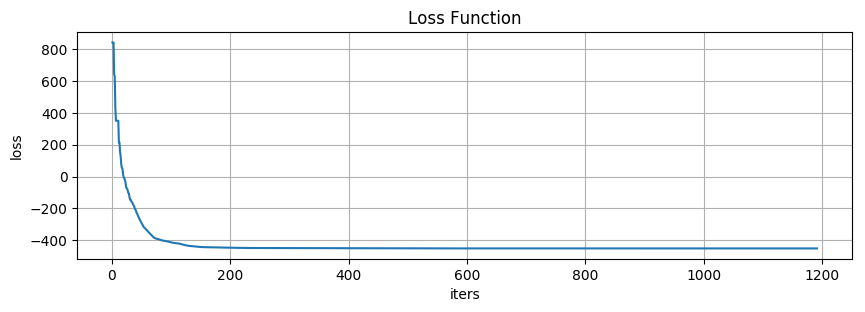

In [139]:
verbose=1
st =  time.process_time()
st2 = time.time()
loss = m2.optimize('scg', messages=verbose,max_iters=5000)
end =  time.process_time()
end2 = time.time()
print(str('CPU+SystemTime:')+str(end-st)+' '+str('seconds'))
print(str('Code Run Time:')+str(end2-st2)+' '+str('seconds'))
i=list(range(1,len(loss.trace)+1))
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
#pyplot.ylim(-20,40)  # set the ylim to ymin, ymax
pyplot.grid()
pyplot.plot(i,loss.trace)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
#pyplot.yscale('log')
pyplot.title('Loss Function')

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1867: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


(0, 1.5)

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


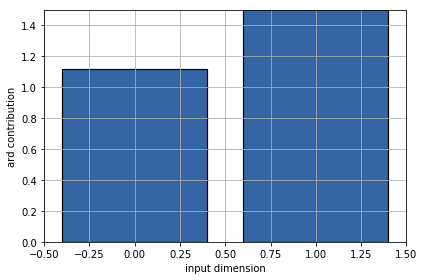

In [140]:
m2.kern.plot_ARD()
plt.grid()
plt.ylim([0,1.5])

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


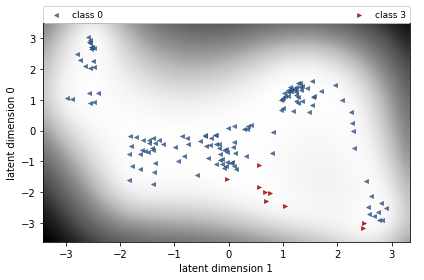

In [141]:
m2.plot_latent(m2.data_labels)

In [142]:
K_orig = m2.kern.K(m2.X,m2.X) + np.eye(m2.X.shape[0])*(1/m2.Gaussian_noise.variance)

In [143]:
t = np.array(m2.X)
dd_proj = distance_matrix(t)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)
cont = []

Neearest neighbourboost size k =5 Continuity:0.7990985915492957
Neearest neighbourboost size k =10 Continuity:0.7727385377942999
Neearest neighbourboost size k =20 Continuity:0.7420641562064156
Neearest neighbourboost size k =40 Continuity:0.7002905027932961
Neearest neighbourboost size k =60 Continuity:0.6768944911297852
Neearest neighbourboost size k =75 Continuity:0.619557957957958


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

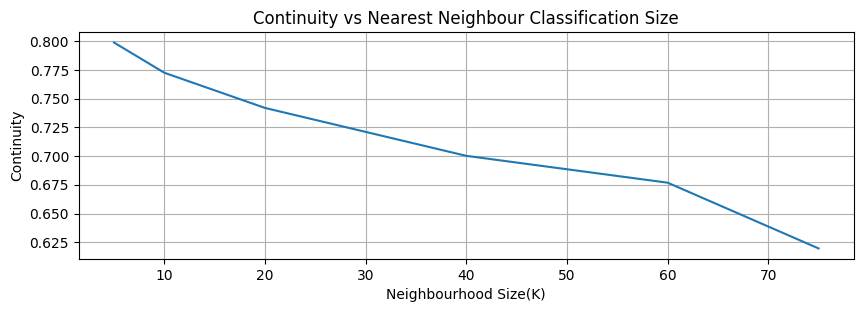

In [166]:
ks=[5,10,20,40,60,75]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
pyplot.grid()
#pyplot.yscale('log')
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =5 Trust:0.9357183098591549
Neearest neighbourboost size k =10 Trust:0.904728624535316
Neearest neighbourboost size k =20 Trust:0.8365216178521618
Neearest neighbourboost size k =40 Trust:0.7784841713221602
Neearest neighbourboost size k =60 Trust:0.7262521008403362
Neearest neighbourboost size k =75 Trust:0.6512024024024023


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

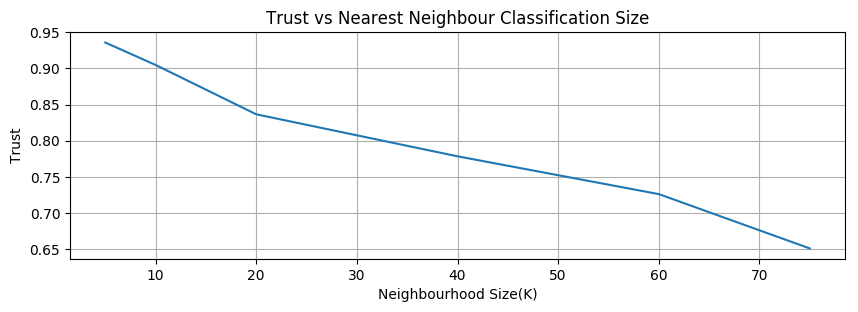

In [167]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
#pyplot.yscale('log')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

Text(0.5,1.05,'GPLVM-MAP, Full Covariance')

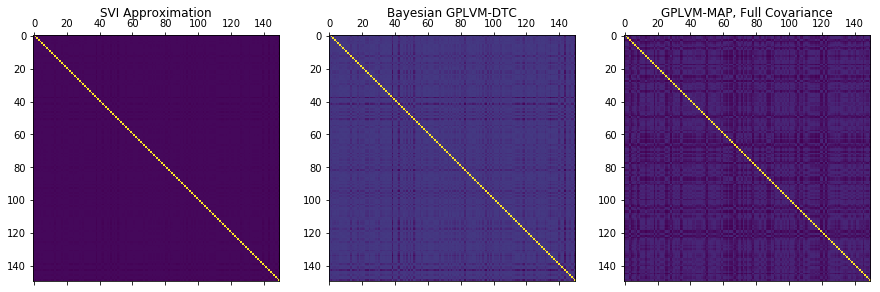

In [168]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].matshow(K)
ax[0].set_title('SVI Approximation')
ax[1].matshow(Kff)
ax[1].set_title('Bayesian GPLVM-DTC')
ax[2].matshow(K_orig)
ax[2].set_title('GPLVM-MAP, Full Covariance')

In [169]:
N= y.shape[0]
Q = 2
D=4
Join2 = []
for sample in VS:
    Join2.append(Joint_Prob(Y,sample.detach().numpy(),N,D,Q,m2,K_orig))

 /home/aneeqr/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:2010: RuntimeWarning:overflow encountered in det


In [170]:
Rs,Rs2 = log_Ratios(qx,Join2)

In [171]:
print('K:'+ str(psisloo(np.array(Rs2)))) 

K:(nan, nan, inf)


 /home/aneeqr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning:invalid value encountered in subtract
 /home/aneeqr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning:invalid value encountered in greater
 /home/aneeqr/.local/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning:invalid value encountered in reduce


In [ ]:
thefile = open('tester2.txt', 'w')
for item in Rs2:
    thefile.write("%s\n" % item)

## Bayesian GPLVM and GPLVM Posterior Samples

In [ ]:
Sanples = m.posterior_samples(X=m.X.mean,likelihood=GPy.likelihoods.Gaussian(),full_cov=True,size=10)

In [ ]:
Samples = m.posterior_samples_f(X=m.X.mean,full_cov=True,size=2)

In [174]:
#F = np.random.multivariate_normal(mu, K, num_samps).T
#F = np.random.multivariate_normal(np.array(m.X.mean), m.kern.K(m.X.mean,m.X.mean), 100).T
#F[0].shape

In [ ]:
np.random.seed(1)
samples = np.random.multivariate_normal(np.array(m.X.mean),)

In [ ]:
N= y.shape[0]
Q = 2
D=4
Join3 = []
for sample in Samples:
    Join3.append(Joint_Prob(Y,sample,N,D,Q,m2,K_orig))

In [ ]:
def Var2(X,D,K_new):
    #K_inv = pdinv(K_new)[0]
    K_inv = np.linalg.inv(K_new) 
    temp = np.matmul(np.matmul(X.T,K_inv),X) 
    qx = -0.5*(K.shape[0]*(D))*(np.log(np.pi*2)) - D/2*np.log(np.linalg.det(K_new)) - 0.5*np.trace(temp)
    return qx

In [ ]:
qx2 = []
for sample in Samples:
    qx2.append(Var2(sample,D=2,K_new=Kff))

In [90]:
Rs,Rs2 = log_Ratios(qx2,Join3)

NameError: name 'qx2' is not defined

In [173]:
#print('K:'+ str(psisloo(np.array(Rs2)))) 

In [9]:
def psisloo(log_lik, **kwargs):
    r"""PSIS leave-one-out log predictive densities.

    Computes the log predictive densities given posterior samples of the log
    likelihood terms :math:`p(y_i|\theta^s)` in input parameter `log_lik`.
    Returns a sum of the leave-one-out log predictive densities `loo`,
    individual leave-one-out log predictive density terms `loos` and an estimate
    of Pareto tail indeces `ks`. The estimates are unreliable if tail index
    ``k > 0.7`` (see more in the references listed in the module docstring).

    Additional keyword arguments are passed to the :meth:`psislw()` function
    (see the corresponding documentation).

    Parameters
    ----------
    log_lik : ndarray
        Array of size n x m containing n posterior samples of the log likelihood
        terms :math:`p(y_i|\theta^s)`.

    Returns
    -------
    loo : scalar
        sum of the leave-one-out log predictive densities

    loos : ndarray
        individual leave-one-out log predictive density terms

    ks : ndarray
        estimated Pareto tail indeces

    """
    # ensure overwrite flag in passed arguments
    kwargs['overwrite_lw'] = True
    # log raw weights from log_lik
    lw = -log_lik
    # compute Pareto smoothed log weights given raw log weights
    lw, ks = psislw(lw, **kwargs)
    # compute
    lw += log_lik
    loos = sumlogs(lw, axis=0)
    loo = loos.sum()
    #print('Ks'+str(ks))
    return loo, loos, ks

def psislw(lw, Reff=1.0, overwrite_lw=False):
    """Pareto smoothed importance sampling (PSIS).

    Parameters
    ----------
    lw : ndarray
        Array of size n x m containing m sets of n log weights. It is also
        possible to provide one dimensional array of length n.

    Reff : scalar, optional
        relative MCMC efficiency ``N_eff / N``

    overwrite_lw : bool, optional
        If True, the input array `lw` is smoothed in-place, assuming the array
        is F-contiguous. By default, a new array is allocated.

    Returns
    -------
    lw_out : ndarray
        smoothed log weights
    kss : ndarray
        Pareto tail indices

    """
    if lw.ndim == 2:
        n, m = lw.shape
    elif lw.ndim == 1:
        n = len(lw)
        m = 1
    else:
        raise ValueError("Argument `lw` must be 1 or 2 dimensional.")
    if n <= 1:
        raise ValueError("More than one log-weight needed.")

    if overwrite_lw and lw.flags.f_contiguous:
        # in-place operation
        lw_out = lw
    else:
        # allocate new array for output
        lw_out = np.copy(lw, order='F')

    # allocate output array for kss
    kss = np.empty(m)
    #print(kss)

    # precalculate constants
    cutoff_ind = - int(np.ceil(min(0.2 * n, 3 * np.sqrt(n / Reff)))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)
    logn = np.log(n)
    k_min = 1/3

    # loop over sets of log weights
    for i, x in enumerate(lw_out.T if lw_out.ndim == 2 else lw_out[None, :]):
        # improve numerical accuracy
        x -= np.max(x)
        # sort the array
        x_sort_ind = np.argsort(x)
        # divide log weights into body and right tail
        xcutoff = max(
            x[x_sort_ind[cutoff_ind]],
            cutoffmin
        )
        expxcutoff = np.exp(xcutoff)
        tailinds, = np.where(x > xcutoff)
        x2 = x[tailinds]
        n2 = len(x2)
        if n2 <= 4:
            # not enough tail samples for gpdfitnew
            k = np.inf
        else:
            # order of tail samples
            x2si = np.argsort(x2)
            # fit generalized Pareto distribution to the right tail samples
            np.exp(x2, out=x2)
            x2 -= expxcutoff
            k, sigma = gpdfitnew(x2, sort=x2si)
        if k >= k_min and not np.isinf(k):
            # no smoothing if short tail or GPD fit failed
            # compute ordered statistic for the fit
            sti = np.arange(0.5, n2)
            sti /= n2
            qq = gpinv(sti, k, sigma)
            qq += expxcutoff
            np.log(qq, out=qq)
            # place the smoothed tail into the output array
            x[tailinds[x2si]] = qq
            # truncate smoothed values to the largest raw weight 0
            x[x > 0] = 0
        # renormalize weights
        x -= sumlogs(x)
        # store tail index k
        kss[i] = k
        #print(k)

    # If the provided input array is one dimensional, return kss as scalar.
    if lw_out.ndim == 1:
        kss = kss[0]

    return lw_out, kss

def sumlogs(x, axis=None, out=None):
    """Sum of vector where numbers are represented by their logarithms.

    Calculates ``np.log(np.sum(np.exp(x), axis=axis))`` in such a fashion that
    it works even when elements have large magnitude.

    """
    maxx = x.max(axis=axis, keepdims=True)
    xnorm = x - maxx
    np.exp(xnorm, out=xnorm)
    out = np.sum(xnorm, axis=axis, out=out)
    if isinstance(out, np.ndarray):
        np.log(out, out=out)
    else:
        out = np.log(out)
    out += np.squeeze(maxx)
    return out
def gpdfitnew(x, sort=True, sort_in_place=False, return_quadrature=False):
    """Estimate the paramaters for the Generalized Pareto Distribution (GPD)

    Returns empirical Bayes estimate for the parameters of the two-parameter
    generalized Parato distribution given the data.

    Parameters
    ----------
    x : ndarray
        One dimensional data array

    sort : bool or ndarray, optional
        If known in advance, one can provide an array of indices that would
        sort the input array `x`. If the input array is already sorted, provide
        False. If True (default behaviour), the array is sorted internally.

    sort_in_place : bool, optional
        If `sort` is True and `sort_in_place` is True, the array is sorted
        in-place (False by default).

    return_quadrature : bool, optional
        If True, quadrature points and weight `ks` and `w` of the marginal posterior distribution of k are also calculated and returned. False by
        default.

    Returns
    -------
    k, sigma : float
        estimated parameter values

    ks, w : ndarray
        Quadrature points and weights of the marginal posterior distribution
        of `k`. Returned only if `return_quadrature` is True.

    Notes
    -----
    This function returns a negative of Zhang and Stephens's k, because it is
    more common parameterisation.

    """
    if x.ndim != 1 or len(x) <= 1:
        raise ValueError("Invalid input array.")

    # check if x should be sorted
    if sort is True:
        if sort_in_place:
            x.sort()
            xsorted = True
        else:
            sort = np.argsort(x)
            xsorted = False
    elif sort is False:
        xsorted = True
    else:
        xsorted = False

    n = len(x)
    PRIOR = 3
    m = 30 + int(np.sqrt(n))

    bs = np.arange(1, m + 1, dtype=float)
    bs -= 0.5
    np.divide(m, bs, out=bs)
    np.sqrt(bs, out=bs)
    np.subtract(1, bs, out=bs)
    if xsorted:
        bs /= PRIOR * x[int(n/4 + 0.5) - 1]
        bs += 1 / x[-1]
    else:
        bs /= PRIOR * x[sort[int(n/4 + 0.5) - 1]]
        bs += 1 / x[sort[-1]]

    ks = np.negative(bs)
    temp = ks[:,None] * x
    np.log1p(temp, out=temp)
    np.mean(temp, axis=1, out=ks)

    L = bs / ks
    np.negative(L, out=L)
    np.log(L, out=L)
    L -= ks
    L -= 1
    L *= n

    temp = L - L[:,None]
    np.exp(temp, out=temp)
    w = np.sum(temp, axis=1)
    np.divide(1, w, out=w)

    # remove negligible weights
    dii = w >= 10 * np.finfo(float).eps
    if not np.all(dii):
        w = w[dii]
        bs = bs[dii]
    # normalise w
    w /= w.sum()

    # posterior mean for b
    b = np.sum(bs * w)
    # Estimate for k, note that we return a negative of Zhang and
    # Stephens's k, because it is more common parameterisation.
    temp = (-b) * x
    np.log1p(temp, out=temp)
    k = np.mean(temp)
    if return_quadrature:
        np.negative(x, out=temp)
        temp = bs[:, None] * temp
        np.log1p(temp, out=temp)
        ks = np.mean(temp, axis=1)
    # estimate for sigma
    sigma = -k / b * n / (n - 0)
    # weakly informative prior for k
    a = 10
    k = k * n / (n+a) + a * 0.5 / (n+a)
    if return_quadrature:
        ks *= n / (n+a)
        ks += a * 0.5 / (n+a)

    if return_quadrature:
        #print('K:'+str(k))
        return k, sigma, ks, w
    else:
        #print('K:'+str(k))
        return k, sigma

def gpinv(p, k, sigma):
    """Inverse Generalised Pareto distribution function."""
    x = np.empty(p.shape)
    x.fill(np.nan)
    if sigma <= 0:
        return x
    ok = (p > 0) & (p < 1)
    if np.all(ok):
        if np.abs(k) < np.finfo(float).eps:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            np.negative(x, out=x)
        else:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            x *= -k
            np.expm1(x, out=x)
            x /= k
        x *= sigma
    else:
        if np.abs(k) < np.finfo(float).eps:
            # x[ok] = - np.log1p(-p[ok])
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            np.negative(temp, out=temp)
            x[ok] = temp
        else:
            # x[ok] = np.expm1(-k * np.log1p(-p[ok])) / k
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            temp *= -k
            np.expm1(temp, out=temp)
            temp /= k
            x[ok] = temp
        x *= sigma
        x[p == 0] = 0
        if k >= 0:
            x[p == 1] = np.inf
        else:
            x[p == 1] = -sigma / k
    return x

In [195]:
def log_Ratios(qx,Join):
    Rs = [] # Rations with exp
    Rs2 = [] # Rations without exp just log ratios
    for i in range(len(qx)):
        Rs.append(np.exp(Join[i]-qx[i]))
        Rs2.append(-1*(Join[i]-qx[i]))
    return Rs,Rs2

In [11]:
def d_euclidean(a,b):
    """Returns euclidean distance between vectors a and b"""

    return math.sqrt(sum([ (x - y)**2 for (x,y) in zip (a,b) ]))
def rank_matrix(x):
    """Returns rank matrix from pairwise distance matrix a"""
    
    m = x.argsort()
    r = numpy.zeros(x.shape)

    vectors = x.shape[0]

    for i in range(vectors):
        for j in range(vectors):
            pos = numpy.where(m[i,:]==j)
            r[i,j] = pos[0][0] # there should be a better syntax for this
        
    return r.astype('int')


def centering(x):
    """Center matrix x to origo"""
    return x - x.mean(axis=0)


def double_centering(x):
    """Double center matrix x"""
    pass

def distance_matrix(x, distf=None):
    """Returns distance matrix of pairwise distances between vectors
    stored in array a

    distf is function used to calculate distance between vectors,
    if None, euclidean distance is used
    """

    if distf == None:
        distf = d_euclidean

    vectors = x.shape[0]
    d = numpy.zeros([vectors, vectors])

    for i in range(vectors):
        for j in range(i,vectors):
            dd = distf(x[i,:], x[j,:])
            d[i,j] = dd
            d[j,i] = dd

    return d
def moved_out(nn_orig, nn_proj, i, k):
    """Determine points that were neighbours in the original space,
    but are not neighbours in the projection space.

    nn_orig
      neighbourhood matrix for original data

    nn_proj
      neighbourhood matrix for projection data

    i
      index of the point considered

    k
      size of the neighbourhood considered

    Return a list of indices for 'moved out' values 
    """

    oo = list(nn_orig[i, 1:k+1])
    pp = list(nn_proj[i, 1:k+1])

    for j in pp:
        if (j in pp) and (j in oo):
            oo.remove(j)

    return oo
def moved_in(nn_orig, nn_proj, i, k):
    """Determine points that are neighbours in the projection space,
    but were not neighbours in the original space.

    nn_orig
      neighbourhood matrix for original data

    nn_proj
      neighbourhood matrix for projection data

    i
      index of the point considered

    k
      size of the neighbourhood considered

    Return a list of indices for points which are 'moved in' to point i
    """

    pp = list(nn_proj[i, 1:k+1])
    oo = list(nn_orig[i, 1:k+1])

    for j in oo:
        if (j in oo) and (j in pp):
            pp.remove(j)

    return pp


def scaling_term(k, n):
    """Term that scales measure between zero and one

    k  size of the neighbourhood
    n  number of datapoints
    """

    if k < (n / 2.0):
        return 2.0 / ((n*k)*(2*n - 3*k - 1))
    else:
        return 2.0 / (n * (n - k) * (n - k - 1))


def trustcont_sum(moved, ranks, k):
    """Calculate sum used in trustworthiness or continuity calculation.

    moved

       List of lists of indices for those datapoints that have either
       moved away in (Continuity) or moved in (Trustworthiness)
       projection

    ranks

       Rank matrix of data set. For trustworthiness, ranking is in the
       original space, for continuity, ranking is in the projected
       space.

    k
       size of the neighbournood
    """

    n = ranks.shape[0]
    s = 0

    # todo: weavefy this for speed
    for i in range(n):
        for j in moved[i]:
            s = s + (ranks[i, j] - k)

    a = scaling_term(k, n)

    return 1 - a * s